In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dataset import *
from save_load import *
from NN_library.PINN import *
from NN_library.train_primal_PINN_int import *
from NN_library.train_dual_PINN_int import *
from matplotlib.tri import Triangulation
import utility 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
data = dataset_grid(129, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, 129**2)

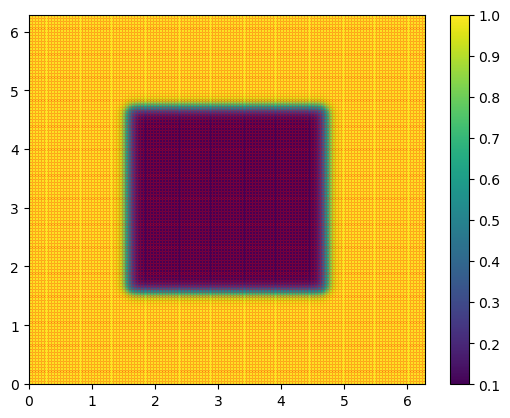

In [6]:
L = 2*np.pi
N = 512 # number of nodes in each direction including the border
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)

eps = 10
def a_function(x,y):
    x_dir = 0.5 + 0.5*np.tanh(eps*np.sin(x-np.pi/2))
    y_dir = 0.5 + 0.5*np.tanh(eps*np.sin(y-np.pi/2))
    a = 1 - 0.9*x_dir*y_dir
    return a

def A_interp(x): 
    x_dir = 0.5 + 0.5*torch.tanh(eps*torch.sin(x-torch.pi/2))
    a = 1 - 0.9*x_dir[:,0]*x_dir[:,1]
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a.view(-1,1,1) * I
    return A

def A_interp_inv(x):  
    x_dir = 0.5 + 0.5*torch.tanh(eps*torch.sin(x-torch.pi/2))
    a = 1 - 0.9*x_dir[:,0]*x_dir[:,1]
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = 1/a.view(-1,1,1) * I
    return A

def A(x):  
    x = x - torch.pi/2
    a = torch.where((x[:,0]<torch.pi)&(x[:,1]<torch.pi)&(x[:,0]>0)&(x[:,1]>0), 0.1, 1.).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a * I
    return A

def A_inv(x):  
    x = x - torch.pi/2
    a = torch.where((x[:,0]<torch.pi)&(x[:,1]<torch.pi)&(x[:,0]>0)&(x[:,1]>0), 0.1, 1.).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = (1 / a) * I
    return A

def H1(x):
    H = torch.zeros_like(x)
    H[:,0] = 1.
    return H

Z = a_function(XY[0].flatten(), XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N), vmin=0.1)
plt.colorbar()
plt.scatter(data[:,0], data[:,1], s = 0.05, c='r')

# Primal PINN

In [ ]:
net_primal = PINN(n_periodic=2, n_hidden=4, n_layers=1, period_len=L)
total_params = sum(p.numel() for p in net_primal.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/PINN/square/IPINN_primal_{eps}_{total_params}'}

Number of parameters: 65


In [5]:
net_primal = load_network(net_primal, args['name']+'_39999', args)
net_primal = net_primal.to(dev)

In [5]:
losses_train, losses_val = train_primal(net_primal, loaders, args, A_interp, H1, L)

Epoch: 0 mean train loss:  6.78594750e+05, bound:  8.06579888e-01
Epoch: 1 mean train loss:  6.78075250e+05, bound:  8.06523860e-01
Epoch: 2 mean train loss:  6.77557375e+05, bound:  8.06467950e-01
Epoch: 3 mean train loss:  6.77041125e+05, bound:  8.06411982e-01
Epoch: 4 mean train loss:  6.76526625e+05, bound:  8.06356192e-01
Epoch: 5 mean train loss:  6.76013625e+05, bound:  8.06300461e-01
Epoch: 6 mean train loss:  6.75502438e+05, bound:  8.06244850e-01
Epoch: 7 mean train loss:  6.74992938e+05, bound:  8.06189418e-01
Epoch: 8 mean train loss:  6.74485125e+05, bound:  8.06134105e-01
Epoch: 9 mean train loss:  6.73979125e+05, bound:  8.06078970e-01
Epoch: 10 mean train loss:  6.73474750e+05, bound:  8.06024075e-01
Epoch: 11 mean train loss:  6.72972250e+05, bound:  8.05969417e-01
Epoch: 12 mean train loss:  6.72471375e+05, bound:  8.05914938e-01
Epoch: 13 mean train loss:  6.71972250e+05, bound:  8.05860758e-01
Epoch: 14 mean train loss:  6.71475000e+05, bound:  8.05806816e-01
Epoch

In [7]:
np.save(f'NN_library/training_data/square/IPINN_primal_{total_params}', np.vstack([losses_train, losses_val]))

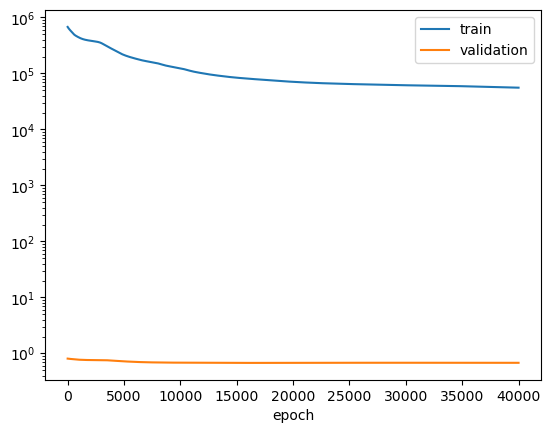

In [6]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [18]:
U1 = net_primal(grid_data).detach().cpu()
error_1_p, _ = PDE_loss(grid_data, net_primal, A_interp, H1)
error_2, _ = PDE_loss(grid_data, net_primal, A, H1)

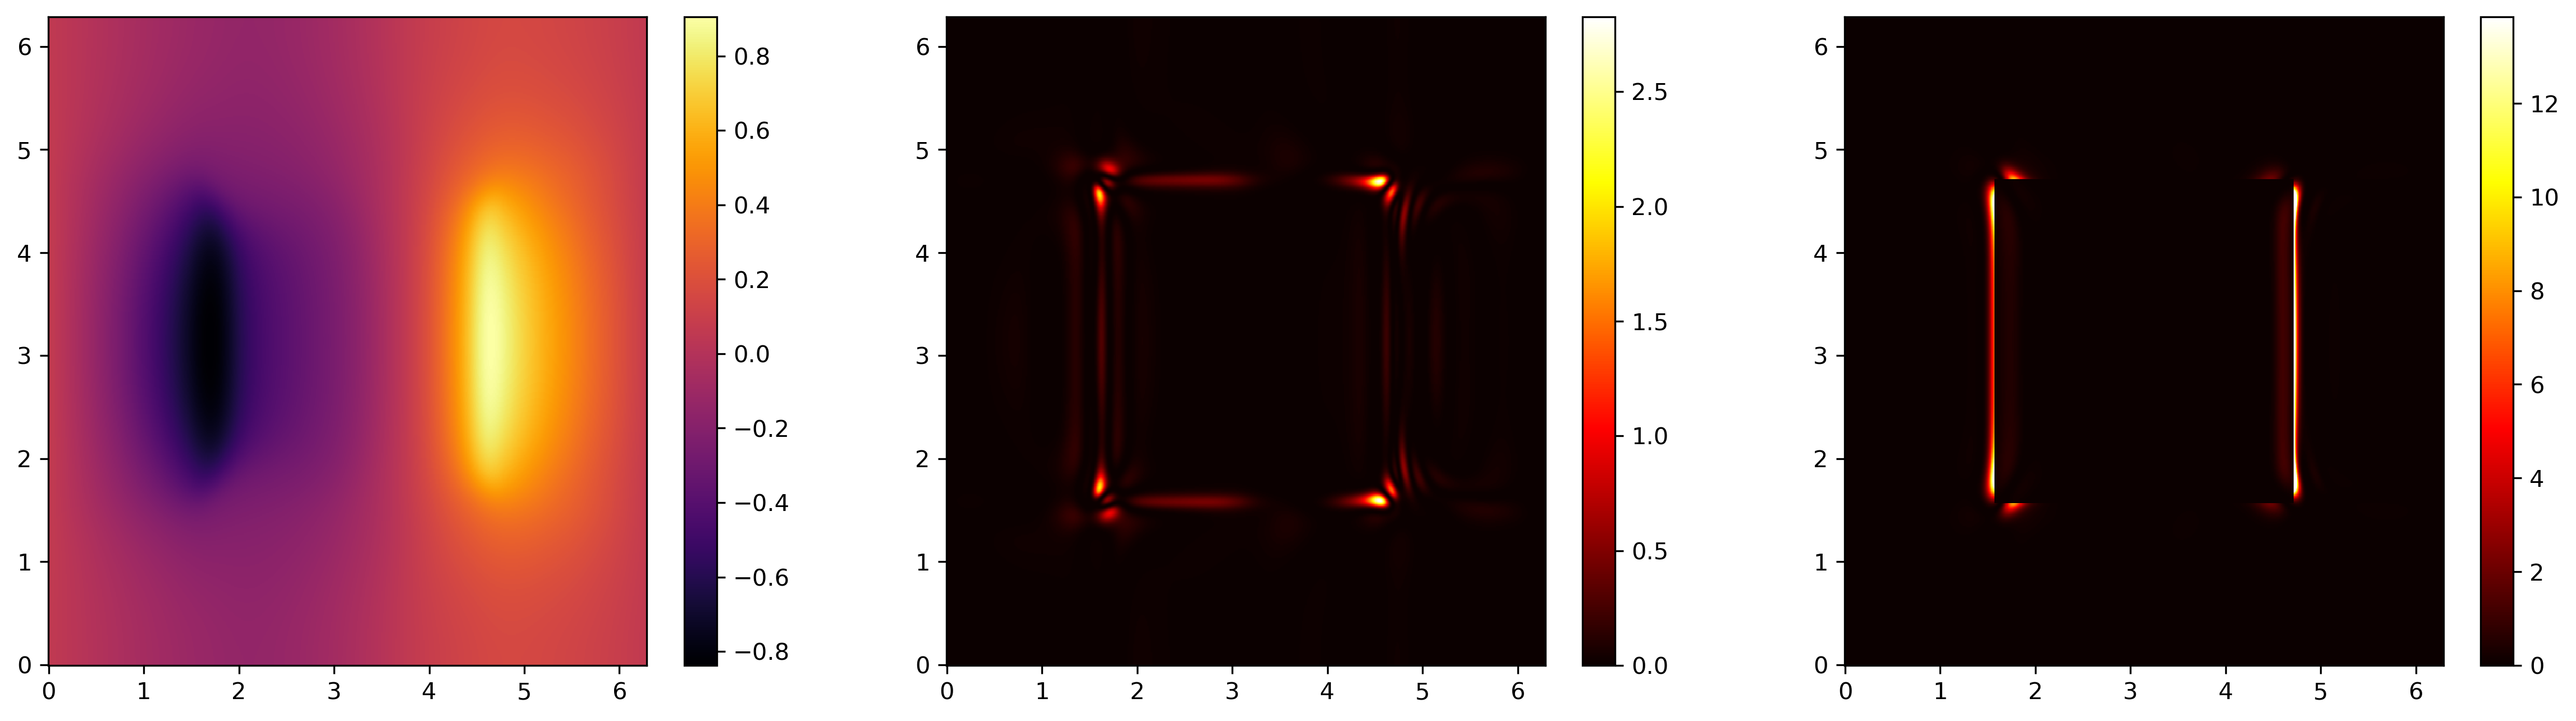

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U1.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_1_p.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], error_2.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos3, ax=axs[2])

In [8]:
N = 1025
data = dataset_grid(N, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, N**2)

In [9]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])

_, q1 = PDE_loss(x, net_primal, A, H1)
_, q2 = PDE_loss(x, net_primal, A_interp, H1)
bound_1 = compute_bound(areas, tri, q1, L).detach()[0].item()
bound_2 = compute_bound(areas, tri, q2, L).detach()[0].item()
print(bound_1, bound_2)

np.save(f'bounds/square/A_u_PINN_{total_params}_{N}.npy', (bound_1, bound_2))

0.6719549298286438 0.6743249893188477


# Dual PINN

In [10]:
net_dual = PINN(n_periodic=2, n_hidden=4, n_layers=1, period_len=L)
total_params = sum(p.numel() for p in net_dual.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/PINN/square/IPINN_dual_{total_params}'}

Number of parameters: 65


In [6]:
net_dual = load_network(net_dual, args['name']+'_39999', args)
net_dual = net_dual.to(dev)

In [11]:
losses_train, losses_val = train_dual(net_dual, loaders, args, A_interp_inv, H1, L)

Epoch: 0 mean train loss:  1.49614185e+03, bound:  3.42144430e-01
Epoch: 1 mean train loss:  1.49610706e+03, bound:  3.42151970e-01
Epoch: 2 mean train loss:  1.49607202e+03, bound:  3.42159569e-01
Epoch: 3 mean train loss:  1.49603687e+03, bound:  3.42167199e-01
Epoch: 4 mean train loss:  1.49600159e+03, bound:  3.42174768e-01
Epoch: 5 mean train loss:  1.49596631e+03, bound:  3.42182457e-01
Epoch: 6 mean train loss:  1.49593079e+03, bound:  3.42190176e-01
Epoch: 7 mean train loss:  1.49589514e+03, bound:  3.42197865e-01
Epoch: 8 mean train loss:  1.49585950e+03, bound:  3.42205614e-01
Epoch: 9 mean train loss:  1.49582373e+03, bound:  3.42213362e-01
Epoch: 10 mean train loss:  1.49578772e+03, bound:  3.42221230e-01
Epoch: 11 mean train loss:  1.49575159e+03, bound:  3.42229038e-01
Epoch: 12 mean train loss:  1.49571558e+03, bound:  3.42236966e-01
Epoch: 13 mean train loss:  1.49567920e+03, bound:  3.42244834e-01
Epoch: 14 mean train loss:  1.49564282e+03, bound:  3.42252731e-01
Epoch

In [31]:
np.save(f'NN_library/training_data/square/IPINN_dual_{total_params}', np.vstack([losses_train, losses_val]))

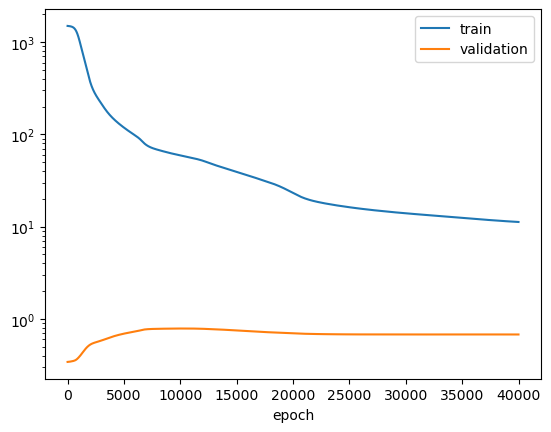

In [32]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [15]:
U2 = net_dual(grid_data).detach().cpu()
error_1_d, _ = PDE_loss_dual(grid_data, net_dual, A_interp_inv, H1)
error_2, _ = PDE_loss_dual(grid_data, net_dual, A_inv, H1)

NameError: name 'PDE_loss_dual' is not defined

NameError: name 'error_1_d' is not defined

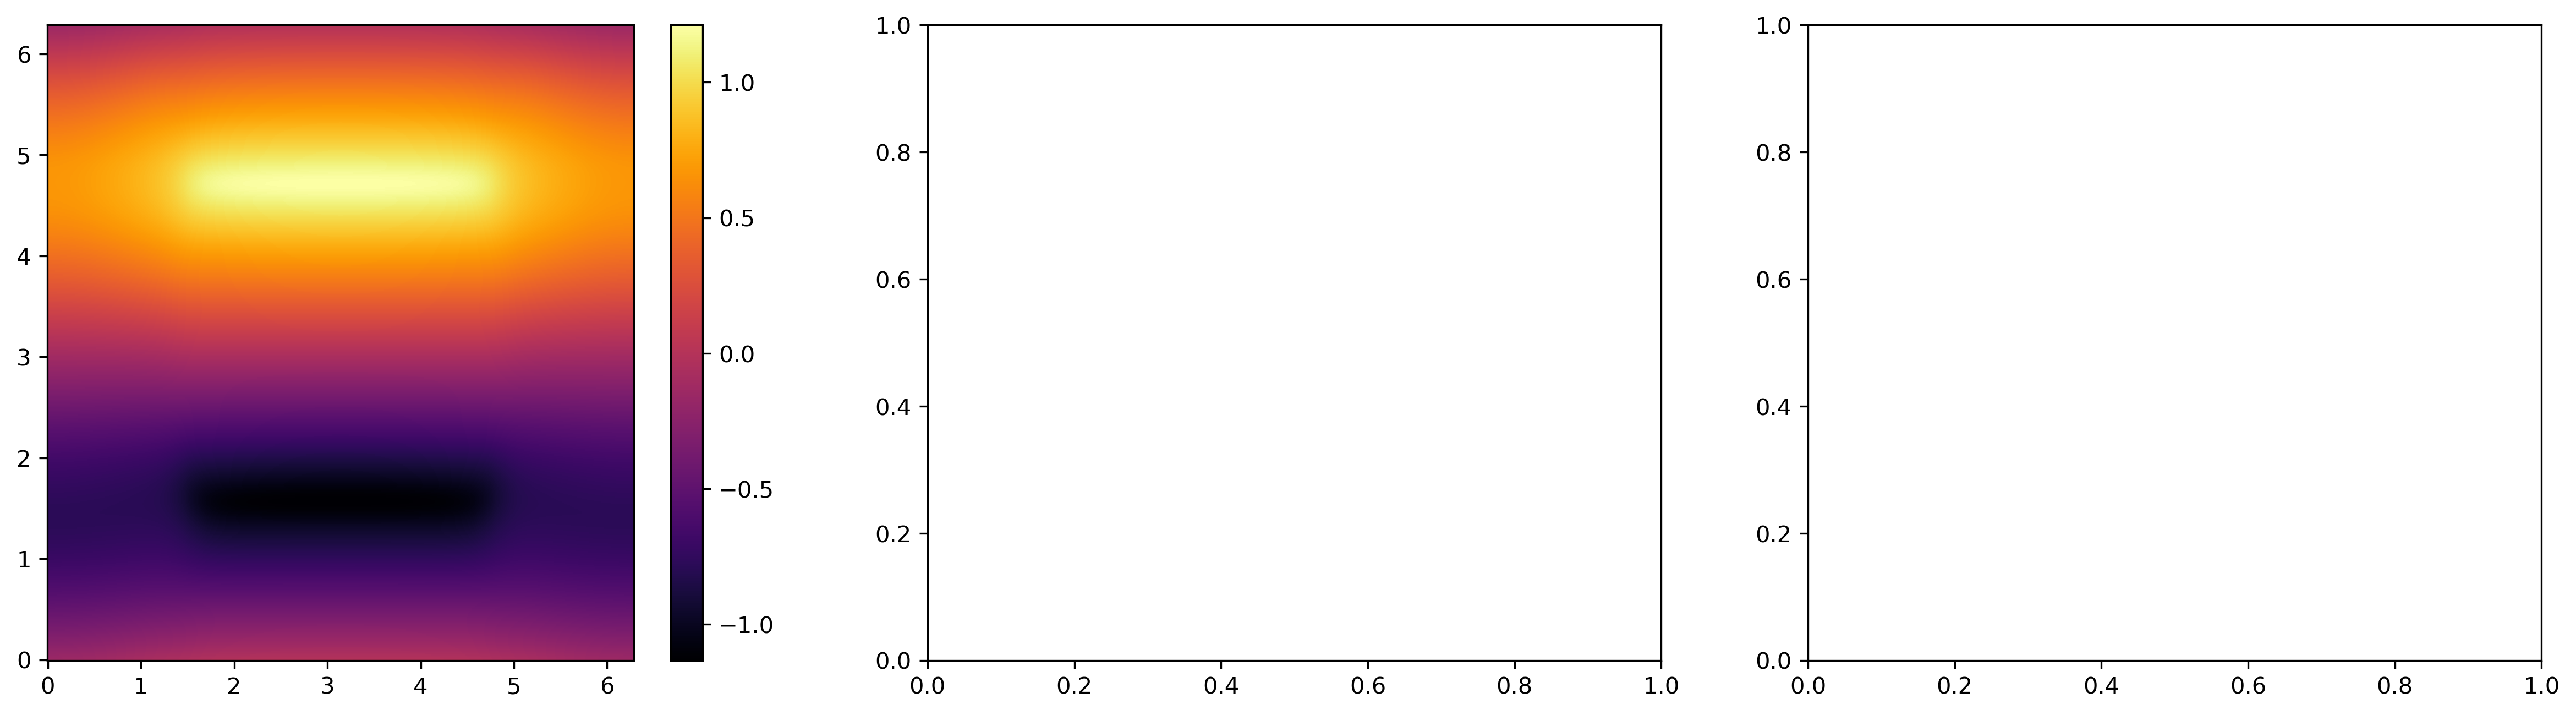

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U2.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_1_d.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], error_2.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos3, ax=axs[2])

In [13]:
N = 129
data = dataset_grid(N, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, N**2)

In [23]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])

_, q1 = PDE_loss_dual_int(x, net_dual, A_inv, H1, areas, tri)
_, q2 = PDE_loss_dual_int(x, net_dual, A_interp_inv, H1, areas, tri)
bound_1 = compute_bound(areas, tri, q1, L).detach()
bound_2 = compute_bound(areas, tri, q2, L).detach()
bound_inv_1 = bound_1[0] / (bound_1[0]**2 - bound_1[1]**2)
bound_inv_2 = bound_2[0] / (bound_2[0]**2 - bound_2[1]**2)

print(bound_inv_1, bound_inv_2)
np.save(f'bounds/square/A_l_PINN_{total_params}_{N}.npy', (bound_inv_1.item(), bound_inv_2.item()))

tensor(0.6227, device='cuda:0') tensor(0.6785, device='cuda:0')


In [24]:
from PDE_losses import PDE_loss, PDE_loss_dual

In [26]:
#U1 = net_primal(grid_data).detach().cpu()
#error_1_p, _ = PDE_loss(grid_data, net_primal, A_interp, H1)
U2 = net_dual(grid_data).detach().cpu()
error_1_d, _ = PDE_loss_dual(grid_data, net_dual, A_interp_inv, H1)

Text(0.5, 1.0, 'Dual solution, PINN, 65 DoFs')

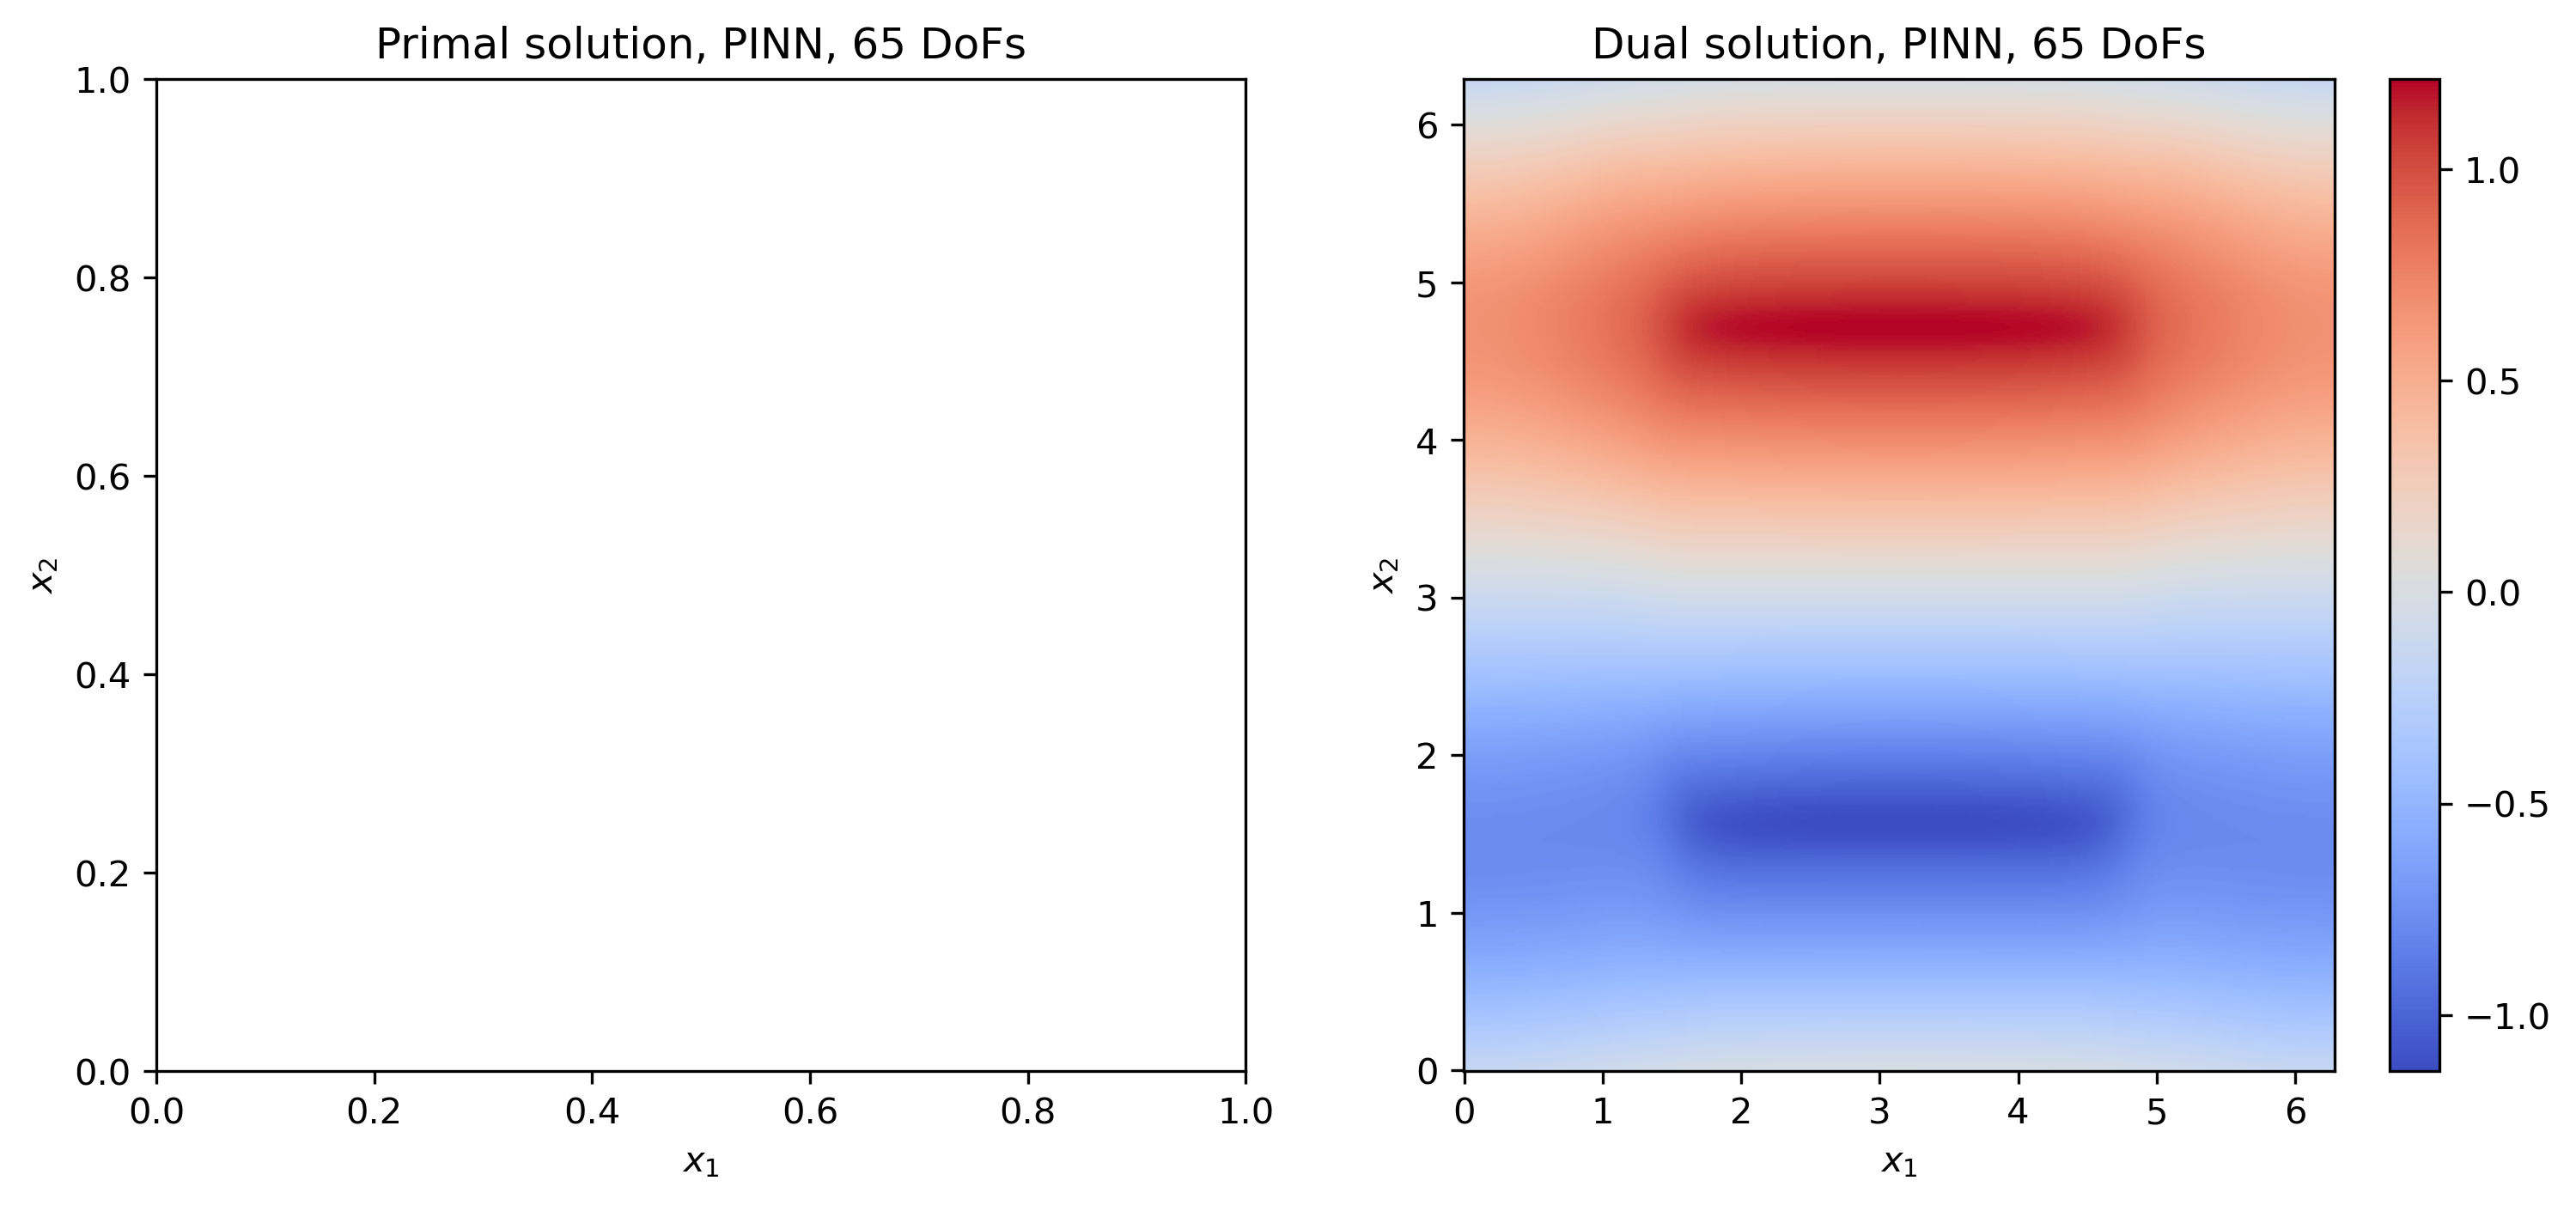

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5), dpi=300)
#pos1 = axs[0].pcolormesh(XY[0], XY[1], U1.reshape(N, N), cmap='coolwarm')
#fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], U2.reshape(N, N), cmap='coolwarm')
fig.colorbar(pos2, ax=axs[1])

axs[0].set_xlabel('$x_1$')
axs[0].set_ylabel('$x_2$')
axs[0].set_title('Primal solution, PINN, 65 DoFs')

axs[1].set_xlabel('$x_1$')
axs[1].set_ylabel('$x_2$')
axs[1].set_title('Dual solution, PINN, 65 DoFs')

Text(0.5, 1.0, 'Dual residual, PINN, 65 DoFs')

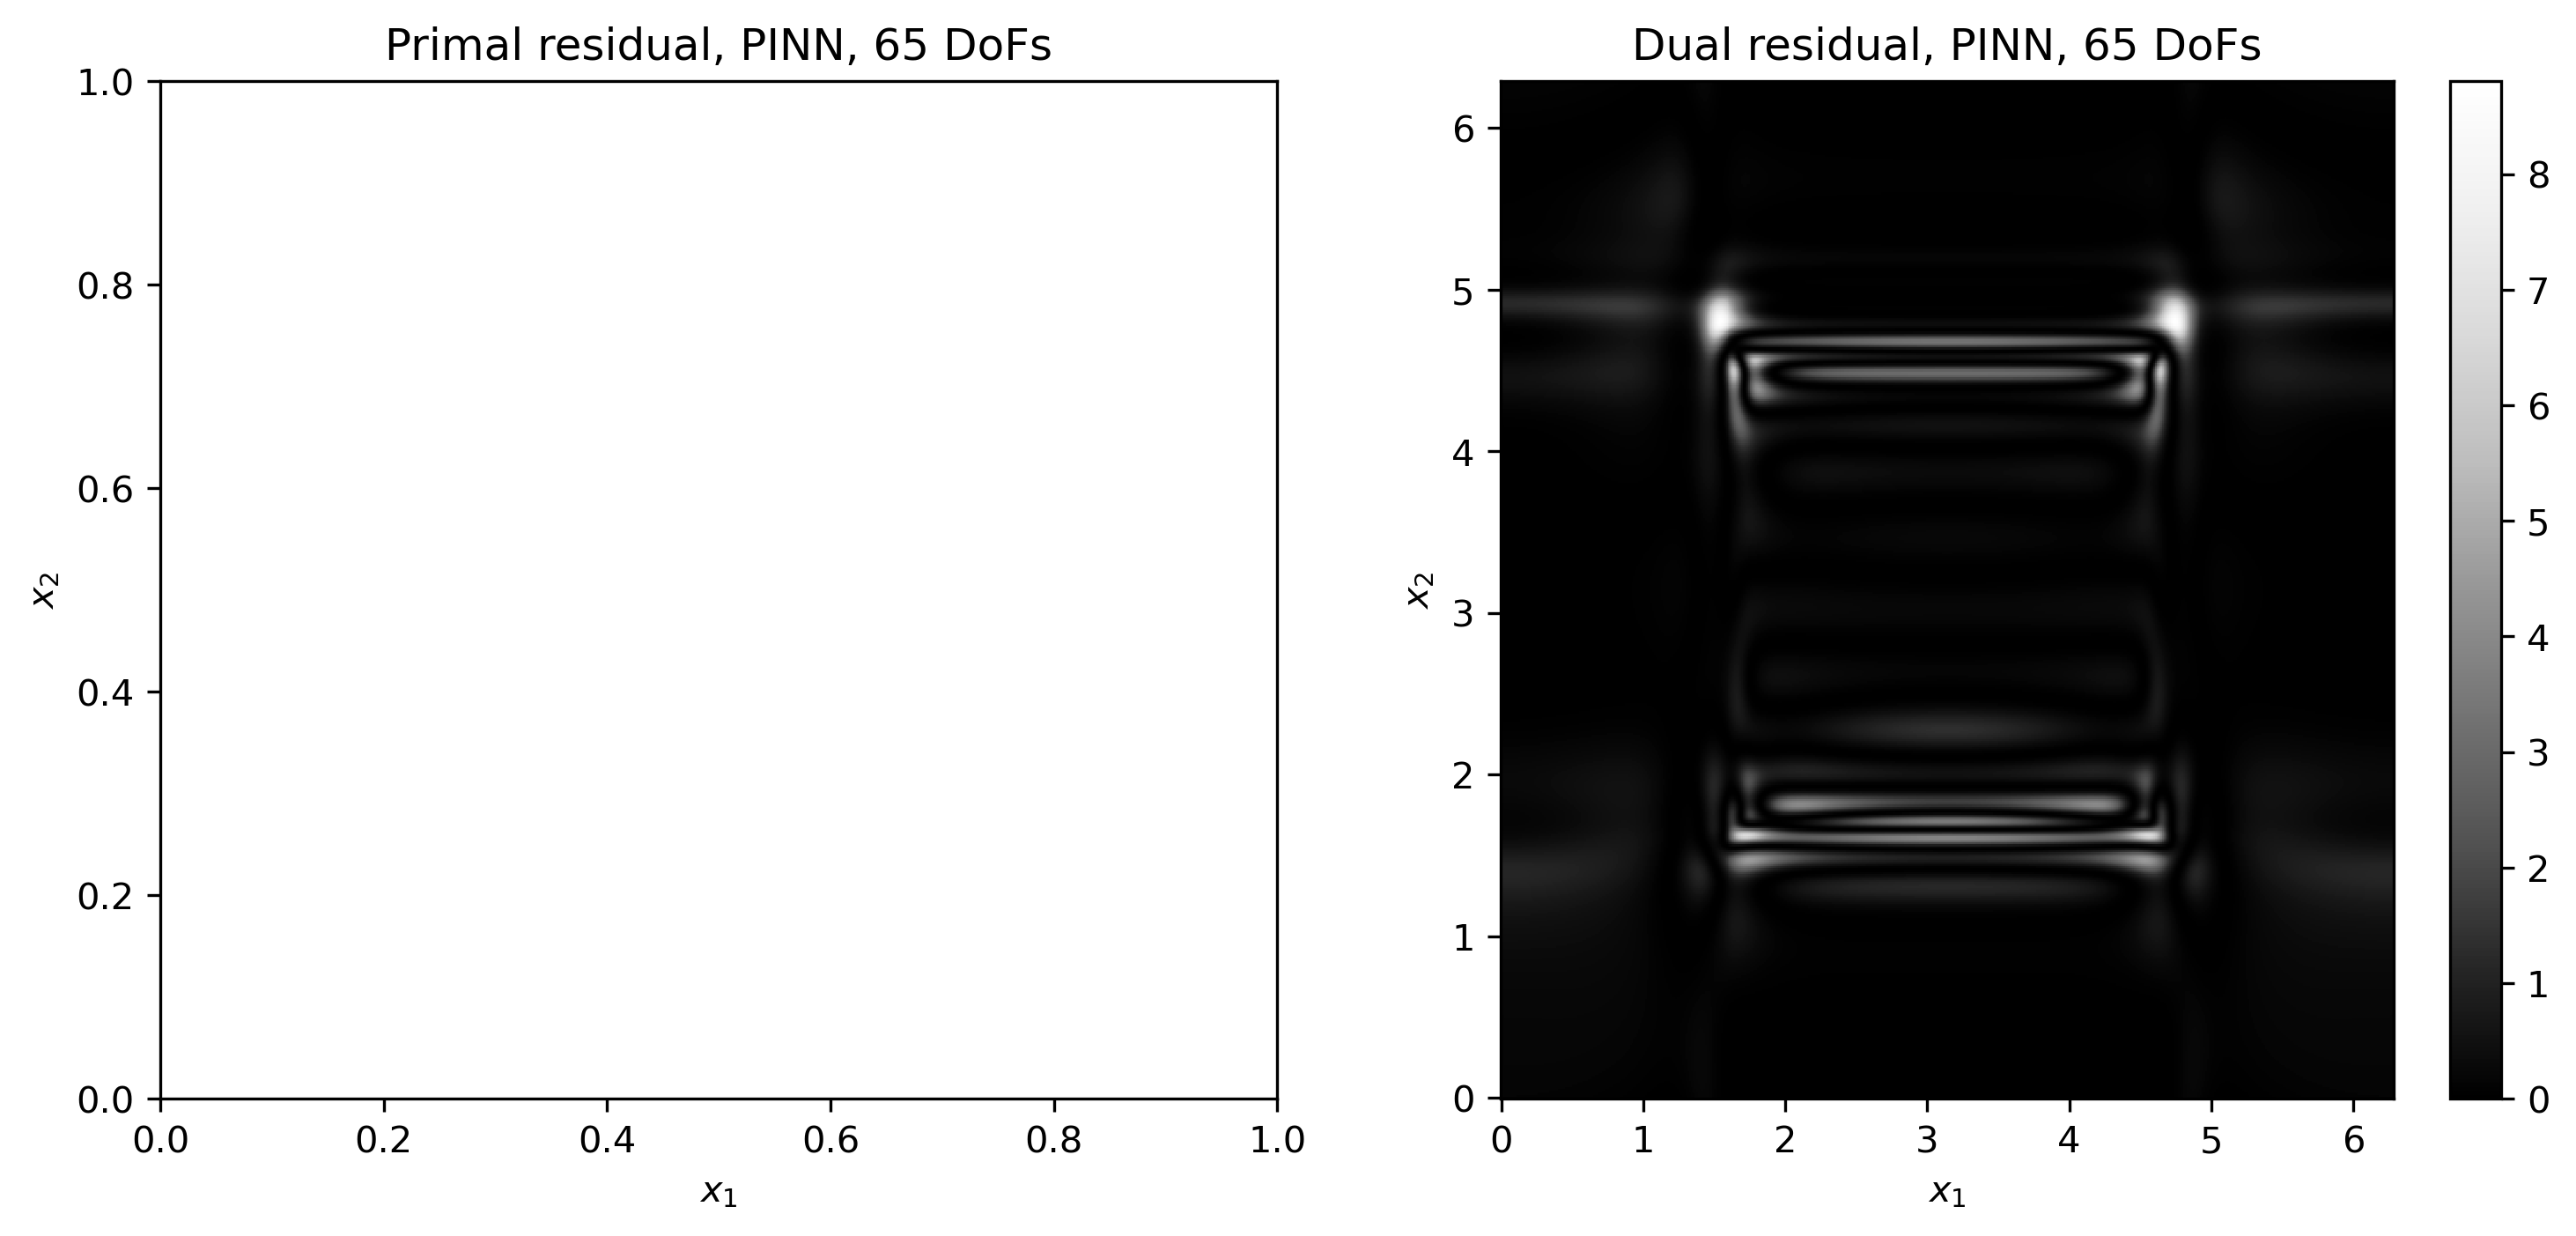

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5), dpi=300)
#pos1 = axs[0].pcolormesh(XY[0], XY[1], error_1_p.detach().cpu().reshape(N, N), cmap='Greys_r')
#fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_1_d.detach().cpu().reshape(N, N), cmap='Greys_r')
fig.colorbar(pos2, ax=axs[1])

axs[0].set_xlabel('$x_1$')
axs[0].set_ylabel('$x_2$')
axs[0].set_title('Primal residual, PINN, 65 DoFs')

axs[1].set_xlabel('$x_1$')
axs[1].set_ylabel('$x_2$')
axs[1].set_title('Dual residual, PINN, 65 DoFs')

In [17]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])

U2 = net_dual(x).detach().cpu().squeeze()

In [20]:
U_fem = np.load('fem-solution.npy')
diff = (U2-U_fem).reshape(129, 129)
diff = diff - diff[:-1,:-1].mean()

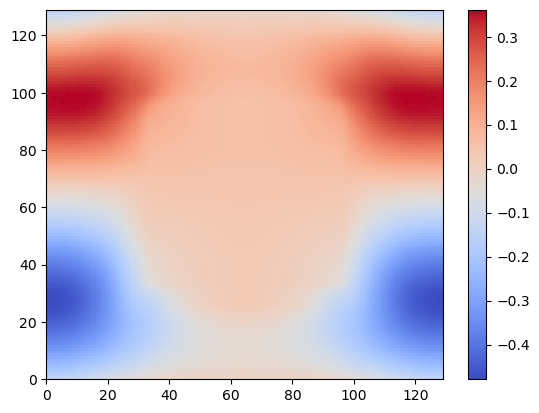

In [21]:
plt.pcolormesh(diff, cmap='coolwarm')
plt.colorbar()